### Introduction

This notebook explores the use of 2 predictive models in solving the problem of forecasting daily sales. The problem, data, and all other information are all from the Kaggle Competition located at: https://www.kaggle.com/c/rossmann-store-sales/overview/description.

**Note: I have already done some data wrangling prior to this notebook in excel and MySQL Workbench**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("train_mod.csv")

df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Month,Season
0,1,5,2015-07-31,5263,555,1,1,d,1,c,a,1270,Jul,SUMMER
1,2,5,2015-07-31,6064,625,1,1,d,1,a,a,570,Jul,SUMMER
2,3,5,2015-07-31,8314,821,1,1,d,1,a,a,14130,Jul,SUMMER
3,4,5,2015-07-31,13995,1498,1,1,d,1,c,c,620,Jul,SUMMER
4,5,5,2015-07-31,4822,559,1,1,d,1,a,a,29910,Jul,SUMMER


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   Store                1017209 non-null  int64 
 1   DayOfWeek            1017209 non-null  int64 
 2   Date                 1017209 non-null  object
 3   Sales                1017209 non-null  int64 
 4   Customers            1017209 non-null  int64 
 5   Open                 1017209 non-null  int64 
 6   Promo                1017209 non-null  int64 
 7   StateHoliday         1017209 non-null  object
 8   SchoolHoliday        1017209 non-null  int64 
 9   StoreType            1017209 non-null  object
 10  Assortment           1017209 non-null  object
 11  CompetitionDistance  1017209 non-null  int64 
 12  Month                1017209 non-null  object
 13  Season               1017209 non-null  object
dtypes: int64(8), object(6)
memory usage: 108.6+ MB


In [3]:
# Suppress scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

In [4]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,558.43,4.00,5773.82,633.15,0.83,0.38,0.18,5415.98
std,321.91,2.00,3849.93,464.41,0.38,0.49,0.38,7710.25
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,280.00,2.00,3727.00,405.00,1.00,0.00,0.00,700.00
50%,558.00,4.00,5744.00,609.00,1.00,0.00,0.00,2320.00
75%,838.00,6.00,7856.00,837.00,1.00,1.00,0.00,6880.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00


**Description of Variables:**

Store - a unique Id for each store

DayOfWeek - 1 to 7 = Monday to Sunday

Date - Date

Sales - the turnover for any given day (this is what we're are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, d = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

Promo - indicates whether a store is running a promo on that day

Month - Month

Season - Season

After some consideration, I have decided to use the following variables for my models. In particular, I chose to not use season because it was too broad and date as it was too sparse ( I would've had to represent it as a 365 sparse vector). Month and DayOfWeek seemed like a better fit for representing a time aspect.

**Predictor Variables:** DayOfWeek, Promo, StateHoliday, SchoolHoliday, StoreType, Assortment, CompetitionDistance, Month

**Target Variable:** Sales

### Data Preprocessing

The training data has 0 missing values which saves us a lot of trouble. There is also no need to scale our variables because most of them are either categorical or binary. The only one we would even consider scaling is the CompetitionDistance variable. However, because of the models that I currently have in mind (Linear Regression and Random Forest), there is no need to scale just yet.

All we need to do for preprocessing is to drop all of the days that the store was closed (because we won't be evaluated on the days with 0 sales) and encode our categorical variables.

In [5]:
# Dropping the records with 0 sales and resetting the index to avoid index errors
df.drop(df[df.Sales == 0].index, inplace = True)
df.reset_index(drop = True, inplace = True)

In [6]:
X = df[['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment', 'Month']].to_numpy()

X.shape

(844338, 5)

In [7]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
X = pd.DataFrame(onehot.fit_transform(X).toarray(), columns = onehot.get_feature_names())

In [8]:
X.insert(0, 'Promo', df[['Promo']], False)
X.insert(1, 'SchoolHoliday', df[['SchoolHoliday']], False)
X.insert(2, 'CompetitionDistance', df[['CompetitionDistance']], False)

# used for graphing feature importance later
col_names = list(X) 

In [9]:
X = X.to_numpy()
y = df[['Sales']].to_numpy()
y = y.flatten()
y.shape

(844338,)

### Modeling

Since our target variable is a continuous numerical value, I have decided to try Linear Regression and Random Forest Models.

### Linear Regression

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
from sklearn.metrics import mean_squared_error

y_pred = lin_reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared = False)
rmse

2729.9095904530323

### Random Forest

**Note:** I had originally conducted grid search with the following parameters: {'n_estimators': [100, 200, 300, 400], 'max_depth': [100, 200, 300]}. However I had to interrupt the kernel as it was still running after 2 hours. I was able to get the best parameters but was unable to save the model. This is why I retrained the model using the best parameters the next day. As you can see even just training this 1 model took 20 minutes.

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_reg = RandomForestRegressor()

param_grid = {'n_estimators': [400], 'max_depth': [200]}

gridsearch = GridSearchCV(rf_reg, param_grid, n_jobs = -1, verbose = 1)

gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 21.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [13]:
gridsearch.best_params_

{'max_depth': 200, 'n_estimators': 400}

In [14]:
gridsearch.best_score_

0.7065374904066772

In [15]:
best_est = gridsearch.best_estimator_

y_pred = best_est.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared = False)
rmse

1643.7360974257883

We see that our root mean squred error improved from 2700 using the Linear Regression Model down to 1600 using the Random Forest Model.

### Plotting Feature Importances

In [16]:
# [best_est.feature_importances_] is important for pandas to know they are row values
# Also sorting the columns by 1st row in descending order
features = pd.DataFrame([best_est.feature_importances_], columns = col_names).sort_values(
            by = 0, axis = 1, ascending = False)

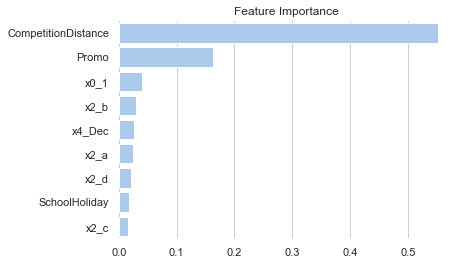

In [17]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Plot the feature importances
sns.set_color_codes("pastel")
sns.barplot(data=features,
            label="Total", color="b", orient = 'h', order = list(features)[0:9])

# Add title and formatting
ax.set_title("Feature Importance")
sns.despine(left=True, bottom=True)

We see that the most important feature in determining the sales of a store on a certain day is the distance from competitors (CompetitionDistance) followed by whether the store is running a promotion or not (Promo).

### Saving the model

In [18]:
from joblib import dump

dump(best_est, 'rossmann_rnd_forest.joblib')

['rossmann_rnd_forest.joblib']

### Prepping the Submission

In [19]:
submit_df = pd.read_csv("test_mod.csv")

submit_df.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Month
0,1,4,2015-09-17,1,1,d,0,c,a,1270,Sep
1,3,4,2015-09-17,1,1,d,0,a,a,14130,Sep
2,7,4,2015-09-17,1,1,d,0,a,c,24000,Sep
3,8,4,2015-09-17,1,1,d,0,a,a,7520,Sep
4,9,4,2015-09-17,1,1,d,0,a,c,2030,Sep


In [20]:
submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Store                41088 non-null  int64 
 1   DayOfWeek            41088 non-null  int64 
 2   Date                 41088 non-null  object
 3   Open                 41088 non-null  int64 
 4   Promo                41088 non-null  int64 
 5   StateHoliday         41088 non-null  object
 6   SchoolHoliday        41088 non-null  int64 
 7   StoreType            41088 non-null  object
 8   Assortment           41088 non-null  object
 9   CompetitionDistance  41088 non-null  int64 
 10  Month                41088 non-null  object
dtypes: int64(6), object(5)
memory usage: 3.4+ MB


Since there are only 11 missing values, I just manually filled them in by looking at the other column values. I filled them all with 1's meaning opening because I saw that 4 entries that were running promotions that day and all 11 entries were in September, not on Sundays, and on days with no State or School Holidays.

I re-imported the data set afterwards, but i'll keep the info above to note that there were originally missing values.

In [21]:
X_submit = submit_df[['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment', 'Month']].to_numpy()

# Note we just transform (instead of fit_transform) X_submit here b/c we have fit it before, this way 
# we'll have consistent X's
X_submit = pd.DataFrame(onehot.transform(X_submit).toarray(), columns = onehot.get_feature_names())

X_submit.insert(0, 'Promo', submit_df[['Promo']], False)
X_submit.insert(1, 'SchoolHoliday', submit_df[['SchoolHoliday']], False)
X_submit.insert(2, 'CompetitionDistance', submit_df[['CompetitionDistance']], False)

X_submit.head()

,Promo,SchoolHoliday,CompetitionDistance,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,...,x4_Dec,x4_Feb,x4_Jan,x4_Jul,x4_Jun,x4_Mar,x4_May,x4_Nov,x4_Oct,x4_Sep
0,1,0,1270,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,1,0,14130,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,1,0,24000,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,1,0,7520,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,1,0,2030,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [22]:
X_submit = X_submit.to_numpy()

y_submit = best_est.predict(X_submit)

The first 15 predictions to see if they look alright

In [23]:
y_submit[0:14]

array([7292.85631556, 7755.16022908, 8939.06951786, 6553.77150198,
       5931.36175036, 5421.22786508, 7996.18805159, 8736.90175186,
       5278.74582738, 5762.75655357, 6215.27294075, 7992.0623125 ,
       7245.49848214, 7530.79754924])

In [24]:
submission = pd.DataFrame(y_submit)
submission.tail()

,0
41083,3046.69
41084,8210.72
41085,5504.07
41086,21319.91
41087,6214.33


In [25]:
submission.to_csv(r'H:\Machine Learning\Projects\Resume ones\Rossmann\submission.csv')

### Results

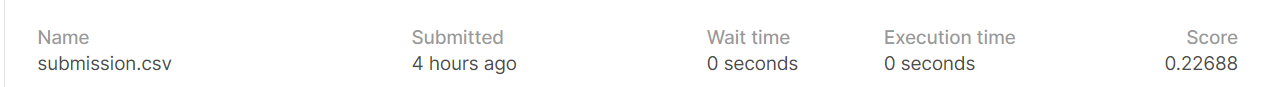

The submission is evaluated on the Root Mean Square Percentage Error (RMSPE) and our model got a score of 0.227 (the lower the score, the better it is) which is pretty good.